Let's assume you're running a small e-commerce website. The first version of your platform is up and running, customers are browsing your catalog but performance in terms of sales are below the expectations. You know that your products are pretty good and you're also running some advertising online to promote your shop. You start looking at the user experience and find the whole process from visiting the product to conclude the purchase is a bit to clunky. There are way to many steps the users has to go through and the churn after the first few steps is alarming. You call you marketing specialist and ask to address the issue. He has a few pretty cool ideas he explains you in your first meeting, but you ask him to come in a week time with a detailed plan of what he thinks you should do.

After a great weekend you come back to the office and have the meeting with the marketing guy, you love his ideas and want to put the next version of the website live ASAP. Take a breath.. we don't want to run that quickly. When setting something live as important as a new website feature you might want to test it first against the existing version. After all, that's the only way you have to measure performance improvements fairly. 

I'm assuming most of you are familiar with the classic A/B testing framework of multiple hypothesis testing. This is a cornerstone of statistics and many books have been written about how you should architect and run your experiment. We are not here to try to reinvent the wheel so we want to build on what already existing but at the same time trying to improve it and address a few common problems we frequently encounter. 

What we want when running an hypothesis test is to return in the shortest period of time the most convincing conclusion. Along these two goals, we also would like to have a framework to test our different competing solutions which is trivial to understand and robust enough to be defendable in front of a veteran Statistician. After all, we don't want to take decision based on spurious results which cannot be replicated.


## What are the advantages of a Bayesian approach?

If you are frequently using randomized experiments with two variants (the control and treatment) you might be familiar with a number of problems linked with such framework. This form of statistical hypothesis testing comes with a few downsides:

* The approach is less than intuitive for a person new to A/B testing and without solid statistics knowledge.
* p-values are often missunderstood and carries a few intrinsic issues:
    * The p-value is not the probability that either A is larger than B or B is larger than A. The p-value is just the likelyhood of a seemingly unlikely event happening in a world governed only by chance.
    * When doing meta-analysis (combining results of different analysis into a final one) we can't treat p-values of different experiments as comparable.
    * The choice of a p-value threshold to reject the null hypothesis is entirely arbitrary.
    * What should we do on those cases where the p-value is slightly above or below the significance threshold?
    * p-values are not a precise measure when studies do not have enough data (what is enough data?).
* Confidence Intervals are, as well, often used improperly.
* Tests can reach statistical significance at a certain point of the experiment, but due to the addition of few new data points could go back to a non significance state.
* The two samples should have the same size (not always true but this complicate things significantly).

There are just a few of the problems linked with a frequentist approach. Fortunately for us, an alternative approach is available, its name is Bayesian A/B Testing. Before we delve deep inside the topic and explain how it works, we might want to ask the question: *"Does a Bayesian method solve at least some of problems listed above?* The answer is *"Yes, a Bayesian approach may solve almost all of these problematics"*. With order, a Bayesian approach has five main advantages over the frequentist method:

1. It’s far easier to interpret its results. For example, we can easily compute the probability that version B is better than version A. In contrast, a frequentist test doesn't even allow this as a possibility.
2. The Bayesian test is measuring the probability at time $t$ that B is better than A (or vice versa). You can look at the data, check if the test is completed, and stop the test early if the result is highly conclusive. This is a major advantage in the business world, when you often come to a point where you must make a decision and cannot wait for a test to reach a certain statistical power.
3. If you believe your test is not going anywhere, you can use your current posteriors as new priors for what is essentially the start of a new test without any major interruptions in your development flow. This mean that you could make further changes to your experiment code, or change a few parameters and don't need to start a new experiment completely from scratch.
4. More importantly, the Bayesian method bakes in uncertainty in a natural way. We don't have to deal anymore with point estimates, but use the random variable distributions.
5. The size of the two samples can differ without complicating our analyses. We can always perform more trials on the smaller sample size to gain inferential "power" if needed.

So, we argued Bayesian approached could be an improvement in this particular scenarios, now.. can we prove it?


## Toy Example: Advertising A/B testing

Let's assume we are running an advertising campaign and want to test two iteration of the same ad against each other. We will simulate 500,000 impressions for each campaign, and use a probabilistic model to decide when a certain impression led to a click or not. To keep things simple we will assume clicks are distributed as Bernoulli random variables, and in particular:

* $Clicks_{Production} \sim Bernoulli(p = 0.0030)$
* $Clicks_{Experiment} \sim Bernoulli(p = 0.0030 * 1.05) = Bernoulli(p = 0.00315)$

In this case the ground truth is that the Experiment is driving a 5% lift compared to the control group. 

In [1]:
import pymc as mc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Create click random variables
impressions = 500000
baseline_true_ctr = 0.0030
experiment_true_ctr = baseline_true_ctr * 1.05

occurrencies_baseline = mc.rbernoulli(baseline_true_ctr, size=impressions)
occurrencies_experiment = mc.rbernoulli(experiment_true_ctr, size=impressions)

print 'Production bidder # clicks:', occurrencies_baseline.sum(), 'out of', impressions, 'impressions.', 'Observed CTR:', "{:.2%}".format(sum(occurrencies_baseline) / float(impressions))
print 'Experiment bidder # clicks:', occurrencies_experiment.sum(), 'out of', impressions, 'impressions.', 'Observed CTR:', "{:.2%}".format(sum(occurrencies_experiment) / float(impressions))

print occurrencies_baseline
print occurrencies_experiment

Production bidder # clicks: 1446 out of 500000 impressions. Observed CTR: 0.29%
Experiment bidder # clicks: 1609 out of 500000 impressions. Observed CTR: 0.32%
[False False False ..., False False False]
[False False False ..., False False False]


As you can see the observed CTR doesn't perfectly match the ground truth. This is something natural to observe in every real life application. The ground truth CTR is the CTR we will observe if we keep running the ad long enough. Unfortunately, we adon't have the time to wait for the observed CTR to converge to the ground truth, because this could take extremely long sometimes. We need to deal with this uncertainty in our framework, which is precisily what the Bayesian A/B testing approach does.

Now, lets assume this is the first time we analyse this kind of data and have very little background knowledge apart from the fact that CTR above 1% are very rare events. We also ignore what could be the lift (if any) of our experiment. We could therefore model our prior distribution as a continuos uniform distribution from 0 to 0.01. This is not a complete un-informative prior (as opposed to the Jeffrey's prior for instance), but is a common way of model our existing knowledge, or lack of.

In [2]:
## Set uniform prior distribution
ctr = mc.Uniform('prior', lower=0, upper=0.015)

print "Random output from our prior distribution:", ctr.random(), ctr.random(), ctr.random()

Random output from our prior distribution: 0.0116351549955 0.0133790889866 0.0139213913557


Now we want to enrich our prior model leveraging the information carried by the observed click / no-click events. 

In [3]:
## Create variable to store observations
observations_baseline = mc.Bernoulli("observations", ctr, value=occurrencies_baseline, observed=True)

## Create model
model = mc.Model([ctr, observations_baseline])

## Compute maximum a posteriori estimates which we will use to try to 'converge' to a solution faster
map_ = mc.MAP(model).fit()

## Run 30,000 Markov Chain Monte Carlo simulations
mcmc = mc.MCMC(model)
mcmc.sample(iter=10000, burn=5000)

## Posterior distribution
posterior = mcmc.trace("prior")[:]

 [-----------------100%-----------------] 10000 of 10000 complete in 171.0 sec

Plotting prior


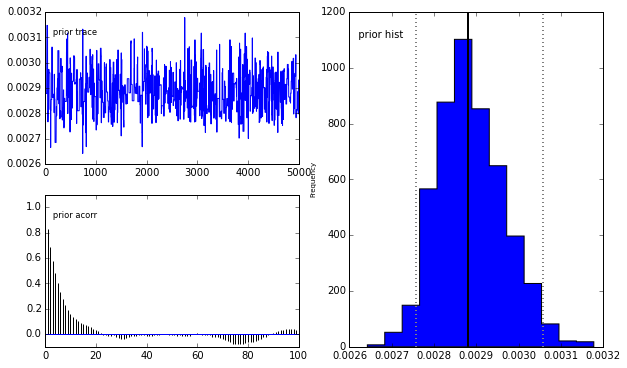

In [4]:
## Check MCMC convergence
mc.Matplot.plot(mcmc)

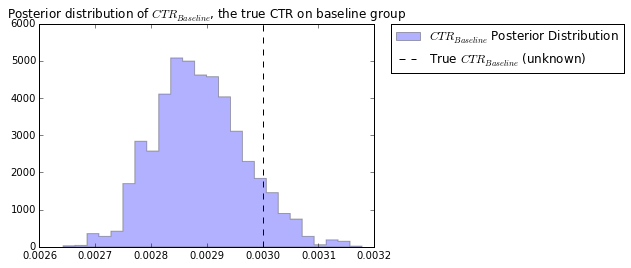

In [5]:
plt.title('Posterior distribution of $CTR_{Baseline}$, the true CTR on baseline group')
plt.vlines(baseline_true_ctr, 0, 6000, linestyle="--", label="True $CTR_{Baseline}$ (unknown)")
plt.hist(posterior, bins=25, histtype='stepfilled', normed=True, alpha=.3, label='$CTR_{Baseline}$ Posterior Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

What we really want to investigate however is the lift driving by our experiment. The lift is computed as:
$$\text{Lift} = \frac{\text{CTR}_\text{Experiment}}{\text{CTR}_\text{Baseline}}$$

To analyse this deterministic function, we must first create it in our model. We will also assume same priors for both distributions. This is in many cases the most appropriate thing to do because the circumstances are that we ignore if our changes in our ad are actually driving any improvement at all. Starting with different priors could (in case of a little number of MCMC runs) artificially impact the chances to *refuse the null hypothesis*, making it harder or easier to happen.

In [6]:
## Set uniform prior distribution
ctr_baseline = mc.Uniform('ctr_baseline', lower=0, upper=0.015)
ctr_experiment = mc.Uniform('ctr_experiment', lower=0, upper=0.015)

## Define the lift function
@mc.deterministic 
def lift(ctr_baseline=ctr_baseline, ctr_experiment=ctr_experiment):
    return ctr_experiment / ctr_baseline

## Set of observations for baseline and experiment
observations_baseline = mc.Bernoulli("observations_baseline", ctr_baseline, value=occurrencies_baseline, observed=True)
observations_experiment = mc.Bernoulli("observations_experiment", ctr_experiment, value=occurrencies_experiment, observed=True)

## Build the model
mcmc = mc.MCMC([ctr_baseline, ctr_experiment, lift, observations_baseline, observations_experiment])
mcmc.sample(iter=10000, burn=5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 303.0 sec

Plotting lift
Plotting ctr_baseline
Plotting ctr_experiment


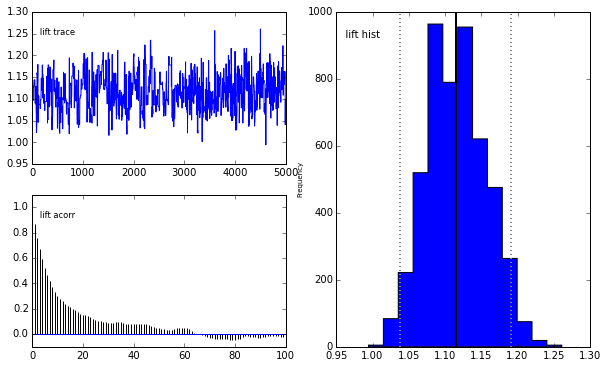

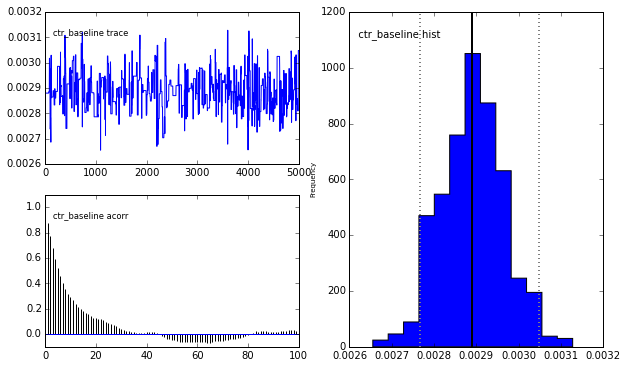

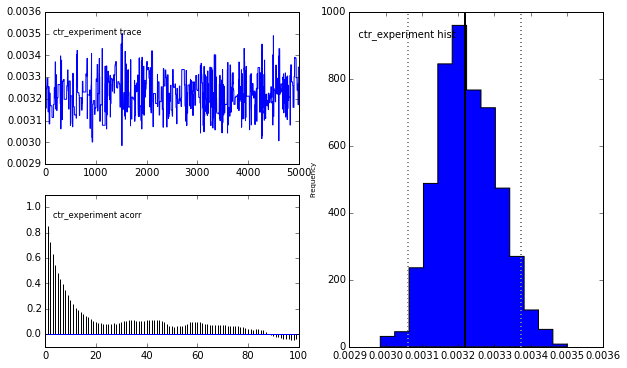

In [7]:
## Check convergence 
mc.Matplot.plot(mcmc, common_scale=True)

In [8]:
ctr_baseline_samples = mcmc.trace("ctr_baseline")[:]
ctr_experiment_samples = mcmc.trace("ctr_experiment")[:]
lift_samples = mcmc.trace("lift")[:]

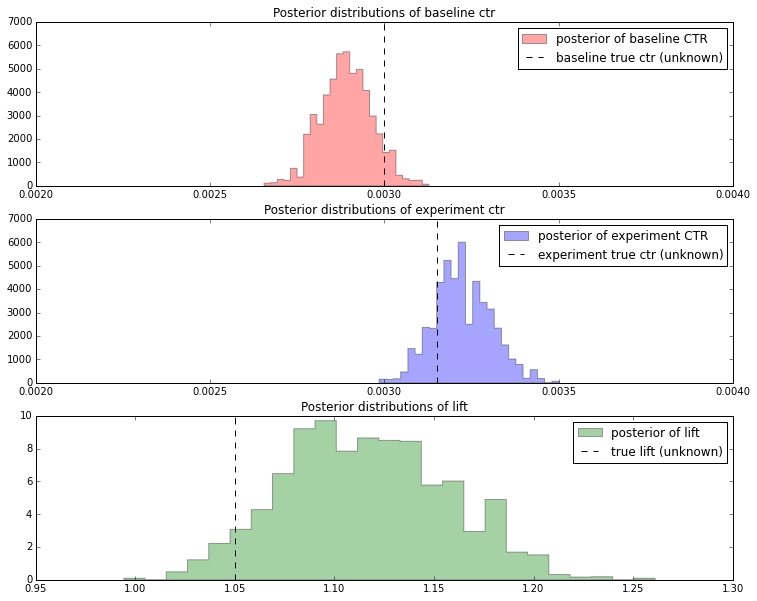

In [12]:
plt.figure(figsize=(12.5,10))

ax = plt.subplot(311)
plt.xlim(0.0020, 0.0040)
plt.ylim(0, 7000)
plt.hist(ctr_baseline_samples, histtype='stepfilled', bins=25, alpha=0.35, label='posterior of baseline CTR', color='red', normed=True)
plt.vlines(baseline_true_ctr, 0, 7000, linestyle="--", label="baseline true ctr (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of baseline ctr")

ax = plt.subplot(312)
plt.xlim(0.0020, 0.0040)
plt.ylim(0, 7000)
plt.hist(ctr_experiment_samples, histtype='stepfilled', bins=25, alpha=0.35, label='posterior of experiment CTR', color='blue', normed=True)
plt.vlines(experiment_true_ctr, 0, 7000, linestyle="--", label="experiment true ctr (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of experiment ctr")

ax = plt.subplot(313)
plt.hist(lift_samples, histtype='stepfilled', bins=25, alpha=0.35, label='posterior of lift', color='green', normed=True)
plt.vlines(experiment_true_ctr / baseline_true_ctr, 0, 10, linestyle="--", label="true lift (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of lift")

First of all it is important to notice how close the posterior distributions are to the true un-observed CTR on both distributions. Bear in mind we started from almost un-informed priors and $500000$ binomial observations which are not that many when clicks happens with such a low frequency. Overall, the Bayesian approach was able to correctly identify the best iteration of our ad. The graphical representation is also very useful when is time to take informative decisions. We should always plot the two (or more) alternative distributions on the same chart in order to clearly identify what is the level of uncertainty associate with each solution. The expected outcome of a random variable doesn't in fact describe what is the certainty associated with its observation. 

In [10]:
## Count the number of samples where lift is less than 0, which represent the probability that the A iteration of 
##   the ad is performing better than B.
print "Probability experiment is worse than baseline: %.3f" % \
    (lift_samples < 0).mean()

print "Probability experiment is better than baseline: %.3f" % \
    (lift_samples > 0).mean()

Probability experiment is worse than baseline: 0.000
Probability experiment is better than baseline: 1.000


## TODO

* Closed form (conjungate priors)
* Benchmark (frequentist approach)


## Bibliography

1. [Sergey Feldman's blog @ RichRelevance](http://engineering.richrelevance.com/bayesian-ab-tests/)
2. [PyMC Documentation](https://pymc-devs.github.io/pymc/)
3. [Bayesian Data Analysis](http://www.amazon.co.uk/dp/1439840954/ref=wl_it_dp_o_pC_nS_ttl?_encoding=UTF8&colid=36OIJMTHG4J3P&coliid=I1NSFYF3IIPC2Z)
4. [Probabilistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
